In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
import sweetviz as sv
sv.config_parser.read('../sweetviz_settings/sweetviz_settings.ini')
# sv.config_parser.read('sweetviz_setting.ini')
import category_encoders as ce
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import lightgbm as gbm
from sklearn.ensemble import RandomForestRegressor as RF

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# データの読み込み

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('train shape', train.shape)
print('test shape' , test.shape)


train shape (207, 12)
test shape (40, 11)


# 前処理
1. remarks : trainにしかない項目はnanに変更
1. weather : 雷電、雪 は雨に丸め込み
1. 祝日フラグ : 前祝日、後祝日のフラグ

In [3]:
### 不要な項目を消す系

# remarksで１個しかないカテゴリは　カテゴリなしにする。
def replace_remarks_cat(df):
    _df = df['remarks'].value_counts().copy()
    _df = _df[_df < 2]
    
    
    for i in _df.index:
        df['remarks'].loc[df['remarks'] == i] = np.nan

# weather 雪と雷電を　雨に置き換え
def replace_weather_cat(df):
    _df = df['weather'].value_counts()
    _df = _df[_df < 2]
    
    for i in _df.index:
        df['weather'].loc[df['weather'] == i] = '雨'

# category_encoding関数
def encoding_func(df, encoding_col_name_list):
    def which_col_is_object_func(df):
        # 列がobjectを抽出してリストに
        keys = list(df.dtypes.loc[df.dtypes == 'object'].index)
        # 辞書化
        values = list(range(len(object_list)))
        object_dic = dict(zip(keys, values))
        print(object_dic)
    
    
    # カテゴリエンコーダーする
    ce_oe = ce.OrdinalEncoder(cols = encoding_col_name_list, handle_unknown = 'impute')
    df = ce_oe.fit_transform(df)

    # カテゴリ番号の確認
    
    for i in range(len(encoding_col_name_list)):
        print(pd.DataFrame(ce_oe.category_mapping[i]))
        print()
    return df


# 休日前flg (category encodingのあとにやる)
def before_holiday_func(df):
    '''
    祝日の前の日にフラグを立てる。
    category encodingのあとに使うこと。
    '''
    df['before_holiday'] = 0
    for i in range(len(df)):
        
        if df['week'].diff(-1).iloc[i] == -1.0:
            df['before_holiday'].iloc[i] = 0        
        
        elif i == len(df):
            df['before_holiday'].iloc[i] = 0
        
        else:
            df['before_holiday'].iloc[i] = 1

            
# 休日後flg (category encodingのあとにやる)
def after_holiday_func(df):
    '''
    祝日の次の日にフラグを立てる。
    category encodingのあとに使うこと。
    '''
    
    df['after_holiday'] = 0

    for i in range(len(df)):
        if i == 1:
            df['week'].iloc[i] == 1
            
        elif df['week'].diff(1).iloc[i] == 1.0:
            df['after_holiday'].iloc[i] = 0
            
        else:
            df['after_holiday'].iloc[i] = 1

## trainとtestの結合

In [4]:
# trainとtestの識別列を追加
train['train_flg'] = True
test['train_flg'] = False

# データの結合
all_data = pd.concat([train, test], axis = 0)
proc_data = all_data.copy()
proc_data['datetime'] = pd.to_datetime(proc_data['datetime'])

## カテゴリデータの処理

In [5]:
# カテゴリデータの処理
replace_remarks_cat(all_data)
replace_weather_cat(all_data)

# nan値の埋め
proc_data['payday'] = proc_data['payday'].fillna(0)
proc_data['remarks'] = proc_data['remarks'].fillna(0)
proc_data['event'] = proc_data['event'].fillna(0)

# 降水量の'--'の処理
proc_data['precipitation'] = proc_data['precipitation'].apply(lambda x : -1 if x == '--' else float(x))

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## 数値データの処理

In [6]:
# kcalのnanをmedianで埋める
proc_data['kcal'] = proc_data['kcal'].fillna(proc_data['kcal'].median())

## エンコーディング 

In [7]:
# encoding
encoding_col_name_list = ['week',
                         'remarks',
                         'event',
                         'weather']

proc_data = encoding_func(proc_data, encoding_col_name_list)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


      col  mapping data_type
月    week        1    object
火    week        2    object
水    week        3    object
木    week        4    object
金    week        5    object
NaN  week       -2    object

                              col  mapping data_type
0                         remarks        1    object
鶏のレモンペッパー焼（50食）、カレー（42食）  remarks        2    object
酢豚（28食）、カレー（85食）          remarks        3    object
お楽しみメニュー                  remarks        4    object
料理長のこだわりメニュー              remarks        5    object
手作りの味                     remarks        6    object
スペシャルメニュー（800円）           remarks        7    object
近隣に飲食店複合ビルオープン            remarks        8    object
NaN                       remarks       -2    object

                 col  mapping data_type
0              event        1    object
ママの会           event        2    object
キャリアアップ支援セミナー  event        3    object
NaN            event       -2    object

         col  mapping data_type
快晴   weather        1    object


## 特徴量作成

In [8]:
# メニューに対する処理
proc_data['curry'] = proc_data['name'].apply(lambda x : 1 if 'カレー' in x else 0)
# all_data['menchikatsu'] = all_data['name'].apply(lambda x : 1 if 'メンチカツ' in x else 0)

In [9]:
# 祝日前後の平日にflg
after_holiday_func(proc_data)
before_holiday_func(proc_data)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### 販売量に対する処理 (時系列の特徴量)

#### 変動率

In [10]:
'''
販売量が現象傾向 という情報を追加したい。
1. trainをshiftしてtestの販売量を埋める
2. trainのnan値になった箇所をmeanで埋める
3. 各yに対して、pcf_changeで特徴量を作る
4. モデル作成時は、最初のmeanを埋めた行を学習させない（使わない)
'''

proc_data['shift_y'] = proc_data['y'].shift(len(test)).fillna(proc_data['y'].median())
proc_data['pcf_change1'] = proc_data['shift_y'].pct_change(1)
proc_data['pcf_change3'] = proc_data['shift_y'].pct_change(3)
proc_data['pcf_change5'] = proc_data['shift_y'].pct_change(5)

#### 移動平均

In [11]:
proc_data['rolling_mean3'] = proc_data['shift_y'].pct_change(3)
proc_data['rolling_mean5'] = proc_data['shift_y'].pct_change(5)

In [12]:
# shift_y は不要なので削除
proc_data.drop(columns = 'shift_y', inplace = True)

In [13]:
proc_data

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg,curry,after_holiday,before_holiday,pcf_change1,pcf_change3,pcf_change5,rolling_mean3,rolling_mean5
0,2013-11-18,90.0,1,0,厚切りイカフライ,412.0,1,1,0.0,1,-1.0,19.8,True,0,1,0,NaN,NaN,NaN,NaN,NaN
1,2013-11-19,101.0,2,1,手作りヒレカツ,412.0,1,1,0.0,1,-1.0,17.0,True,0,0,0,0.000000,NaN,NaN,NaN,NaN
2,2013-11-20,118.0,3,0,白身魚唐揚げ野菜あん,412.0,1,1,0.0,1,-1.0,15.5,True,0,0,0,0.000000,NaN,NaN,NaN,NaN
3,2013-11-21,120.0,4,1,若鶏ピリ辛焼,412.0,1,1,0.0,1,-1.0,15.2,True,0,0,0,0.000000,0.000000,NaN,0.000000,NaN
4,2013-11-22,130.0,5,1,ビッグメンチカツ,412.0,1,1,0.0,1,-1.0,16.1,True,0,0,1,0.000000,0.000000,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,2014-11-21,NaN,5,0,ロコモコ丼,412.0,4,1,0.0,1,-1.0,14.9,False,0,0,1,1.034483,0.282609,0.053571,0.282609,0.053571
36,2014-11-25,NaN,2,1,なすと挽肉のはさみ揚げ,460.0,1,1,0.0,5,1.5,11.4,False,0,1,0,-0.152542,0.111111,0.020408,0.111111,0.020408
37,2014-11-26,NaN,3,1,鶏肉の治部煮風,415.0,1,1,0.0,5,1.0,9.2,False,0,0,0,-0.100000,0.551724,-0.021739,0.551724,-0.021739
38,2014-11-27,NaN,4,0,牛丼風,420.0,1,1,0.0,1,-1.0,15.1,False,0,0,0,0.244444,-0.050847,0.244444,-0.050847,0.244444


# 学習

## Xとyに分割

In [14]:
proc_data.columns

Index(['datetime', 'y', 'week', 'soldout', 'name', 'kcal', 'remarks', 'event',
       'payday', 'weather', 'precipitation', 'temperature', 'train_flg',
       'curry', 'after_holiday', 'before_holiday', 'pcf_change1',
       'pcf_change3', 'pcf_change5', 'rolling_mean3', 'rolling_mean5'],
      dtype='object')

In [15]:
# 前処理したデータをtrain と testに分割
proc_data_train = proc_data.loc[proc_data['train_flg'] == True]
proc_data_test = proc_data.loc[proc_data['train_flg'] == False]

# 不要な列の削除 datetime , name , 
proc_data_train = proc_data_train[['y', 'week', 'soldout', 'kcal', 'remarks', 'event',
       'payday', 'weather', 'precipitation', 'temperature',
       'curry', 'after_holiday', 'before_holiday', 'pcf_change1',
       'pcf_change3', 'pcf_change5', 'rolling_mean3', 'rolling_mean5']]
proc_data_test = proc_data_test[['y', 'week', 'soldout', 'kcal', 'remarks', 'event',
       'payday', 'weather', 'precipitation', 'temperature',
       'curry', 'after_holiday', 'before_holiday', 'pcf_change1',
       'pcf_change3', 'pcf_change5', 'rolling_mean3', 'rolling_mean5']]



In [16]:
# shiftで前半30個くらいのyのデータが全部同じ値なので、学習からはずす
# .drop(df.index[])で行削除ができるが、該当するindex名を全て削除してしまうため、testデータのindexも削除されてしまう。
# なので、train と testに分割してからtrainに対して実施する(全データconcatしてる状態でやるとtestデータが消える)
proc_data_train.drop(proc_data.index[:len(test)], inplace = True, axis = 'index')

## cv

In [18]:
X = proc_data_train.drop(columns = 'y')
y = proc_data_train['y']
print(X.shape, y.shape)

X_index = X.index

(167, 17) (167,)


In [19]:
X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

In [20]:
folds = TimeSeriesSplit(n_splits = 4, test_size = 20)

params = {
    'boosting_type' : 'gbdt',
    'objective' : 'regression',
    'metric' : {'rmse'},
    'max_depth' : 7,
        }


train_score = []
valid_score = []
models = []
train_pred_vs_data_df_list = []
valid_pred_vs_data_df_list = []

for i, (train_index, valid_index) in enumerate(folds.split(proc_data_train)):
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = gbm.Dataset(X_train, y_train)
    valid_data = gbm.Dataset(X_valid, y_valid, reference = train_data)
    
    print('-------------------------------')
    print('model No: ', i)
    
    model = gbm.train(params,
                    train_data,
                    valid_sets = [train_data,valid_data],
                    num_boost_round = 10000,
                    early_stopping_rounds = 10,
                    verbose_eval = 50
                    )
    
    # モデル評価
    # trainのモデル評価
    train_pred = model.predict(X_train)# arrayで返ってくる
    train_pred_vs_data_df = pd.concat([y_train, pd.Series(train_pred,index = train_index)],
                                      axis = 1)# 真値と予測値のｄｆ作成
    train_pred_vs_data_df.columns = ['true','pred']
    train_pred_vs_data_df_list.append(train_pred_vs_data_df)
    
    # validのモデル評価
    valid_pred = model.predict(X_valid)
    valid_pred_vs_data_df = pd.concat([y_valid, pd.Series(valid_pred, index = valid_index)],
                                      axis = 1)
    valid_pred_vs_data_df.columns = ['true','pred']
    valid_pred_vs_data_df_list.append(valid_pred_vs_data_df)
    
    train_score.append(np.sqrt(mean_squared_error(train_pred_vs_data_df['true'],train_pred_vs_data_df['pred'])))
    valid_score.append(np.sqrt(mean_squared_error(valid_pred_vs_data_df['true'],valid_pred_vs_data_df['pred'])))
    
    models.append(model)
    
   

-------------------------------
model No:  0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 12
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 90.241379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No

In [21]:
train_score

[16.1924836699685, 10.575919726138617, 15.807666849877018, 13.91048830898352]

In [22]:
valid_score

[19.468088551466252,
 16.337322625569072,
 21.516712331249934,
 18.339991688201547]

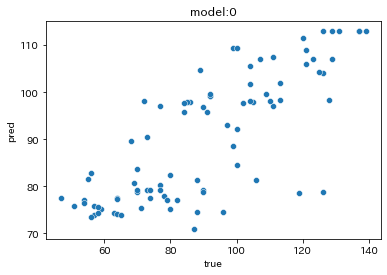

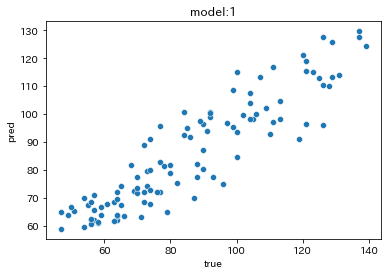

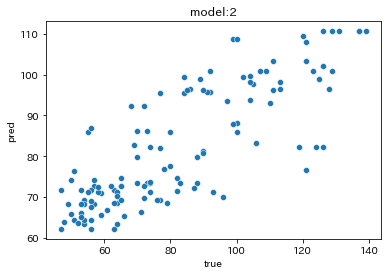

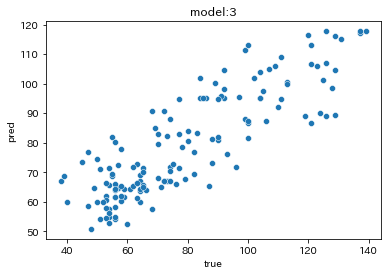

In [23]:
for i in range(len(train_pred_vs_data_df_list)):
    sns.scatterplot(x = 'true', y = 'pred', data = train_pred_vs_data_df_list[i])
    plt.title(label = 'model:'+str(i))
    plt.show()


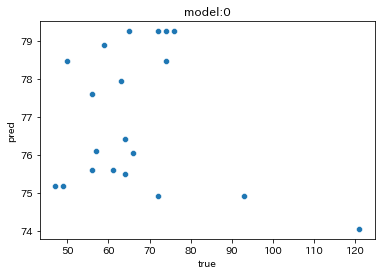

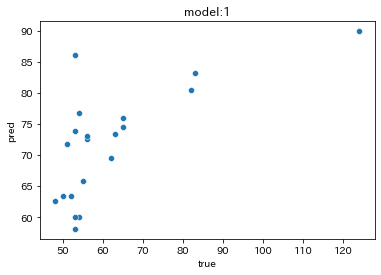

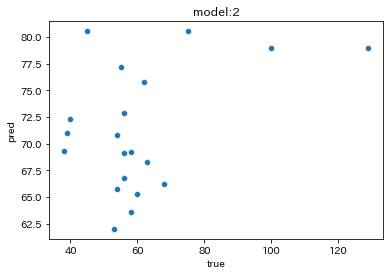

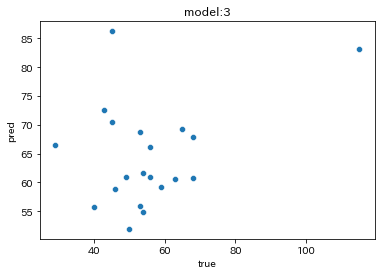

In [36]:
for i in range(len(valid_pred_vs_data_df_list)):
    sns.scatterplot(x = 'true', y = 'pred', data = valid_pred_vs_data_df_list[i])
    plt.title(label = 'model:'+str(i))
    plt.show()


# 全データ学習でエラーでるのでとりあえずモデル4番でtestを予測

### モデルを選択

In [77]:
y_test_pred = models[3].predict(X_test, num_iteration=models[3].best_iteration)

In [93]:
y_test_pred2 = models[3].predict(X_test)

In [94]:
y_test_pred2

array([ 71.90278993,  70.78392617,  69.24878846,  75.90933952,
        62.84398887,  65.88426641,  61.68318461,  89.17167433,
        59.6535186 , 103.1787411 ,  68.17470721,  81.73189989,
        70.71276641,  78.2885635 , 107.27048492,  94.66508279,
        86.85222485,  70.39097747,  72.7328224 ,  67.39101304,
        70.63270708,  81.37209796,  85.43129186, 102.1082529 ,
        73.90994887,  88.13822421,  78.37634275, 114.52973998,
       105.76484524,  69.8580791 ,  95.06226172, 116.22359661,
       113.85592408, 102.1082529 ,  96.37200424, 100.19288574,
       115.65151325, 107.11721619,  98.13710316,  95.02128245])

### 提出データ

<AxesSubplot:xlabel='datetime', ylabel='y'>

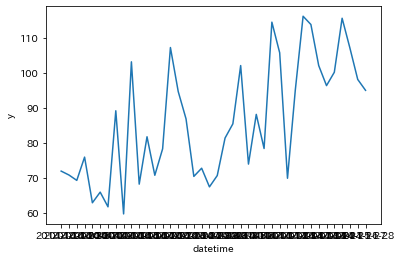

In [92]:
y_test_pred = pd.DataFrame(y_test_pred)
sample_data = pd.read_csv('sample.csv', header = None)
submit_data = pd.concat([sample_data[0], y_test_pred], axis = 1)
submit_data.columns = ['datetime', 'y']
sns.lineplot(x = 'datetime', y = 'y', data = submit_data)

In [105]:
submit_data.to_csv('submit_211025.csv',index = False, header = False)

# testデータで予測

## モデルの作成
全データを学習として使う。

In [54]:
X = proc_data_train.drop(columns = 'y')
y = proc_data_train['y']
print(X.shape, y.shape)

X_index = X.index

(167, 17) (167,)


In [55]:
X_test = proc_data_test.drop(columns = 'y')
y_test = proc_data_test['y']
print(X_test.shape, y_test.shape)


(40, 17) (40,)


In [71]:

params = {
    'boosting_type' : 'gbdt',
    'objective' : 'regression',
    'metric' : 'rmse',
    'max_depth' : 5,
        }


train_score = []


X_train = X
y_train = y

train_data = gbm.Dataset(X_train, y_train)

print('-------------------------------')


model = gbm.train(params,
                  train_set = train_data,
                  valid_sets = None,
                  num_boost_round = 10000,
                  early_stopping_rounds = 10,
                  verbose_eval = 50
                )

# モデル評価
# trainのモデル評価
train_pred = model.predict(X_train)# arrayで返ってくる
train_pred_vs_data_df = pd.concat([y_train, pd.Series(train_pred, index = X.index)],
                                  axis = 1)# 真値と予測値のｄｆ作成
train_pred_vs_data_df.columns = ['true','pred']
train_pred_vs_data_df_list.append(train_pred_vs_data_df)
train_score.append(np.sqrt(mean_squared_error(train_pred_vs_data_df['true'],train_pred_vs_data_df['pred'])))

# testの予測
test_pred = model.predict(X_test)



-------------------------------
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 167, number of used features: 14
[LightGBM] [Info] Start training from score 76.359281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


ValueError: For early stopping, at least one dataset and eval metric is required for evaluation